In [1]:
import random as rd
import os
import math
import statistics
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from numpy.random import choice
from numpy.random import uniform
from numpy.random import normal
from numpy.random import randint
from numpy.random import permutation
from numpy import corrcoef
from numpy import flip
from numpy import around
from numpy import array as nparray
from numpy import arange as arange
from random import choices as rdchoices
from random import uniform as rduniform
import numba as nb
import time
import scipy.stats
from scipy.stats import multivariate_normal as mvn
from sklearn.utils import shuffle
import statistics
import matplotlib.pyplot as plt
from matplotlib import pyplot as mp
from collections import Counter
from progress.bar import Bar
from scipy.stats import skewnorm
#import pandas as pd
from itertools import chain
import cProfile, pstats
from tqdm import tqdm
import seaborn as sns

/Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
class femaleSimulateIBI:
    
    def __init__(self, f):
        
        self.ID = f
        self.status, self.cycleDay = "nonCycling", False
        self.conceptionProbability, myConceptionProbabilityList = 0, []
        self.daysUntilCycling = randint(rangeOfNonCyclingDays+1)
        self.daysUntilConception = False
        self.myConceptionProbabilityList = []
        self.genes = [uniform(0,1)] + [uniform(0,nMales)]
        self.reproductiveSuccess = 0
        self.cost = 0
        
    def switchToCycling(self):
            
        self.cycleDay = 0
        self.status = "cycling"
        self.daysUntilConception = round(normal(meanDaysToConception, sdDaysToConception))
        self.conceptionProbability = conceptionProbabilityList[0]
        
    def switchToDone(self):
        
        self.cycleDay = False
        self.status = "done"
        

In [3]:
class male:
    
    def __init__(self, m):
        
        self.ID = m
        self.genes = [uniform(0,1)] + [uniform(0,nMales)]
        self.fitness = self.genes[0]
        self.dominance = self.genes[1]
        self.cost = self.dominance * (1 - self.fitness)
        self.reproductiveSuccess = 0
        

In [49]:
class groupOfFemales:
    
    def __init__(self):

        
        self.listOfFemales = [femaleSimulateIBI(f) for f in range(nFemales)]
        self.listOfMales = [male(m) for m in range(nMales)]
        
        self.modelDays = 0
        self.maleDominances()
    
    def go(self):
        
            for r in range(10000):
                self.modelDays += 1
                if all([item.status =="done" for item in self.listOfFemales]):
                    break

                self.makeMatingPairs()

                for f in [item for item in self.listOfFemales if item.status == "cycling"]:
                    f.daysUntilConception -= 1
                    f.cycleDay = f.cycleDay + 1 if f.cycleDay < cycleLength - 1 else 0
                    f.conceptionProbability = conceptionProbabilityList[f.cycleDay]
                    f.myConceptionProbabilityList += [f.conceptionProbability]
                    f.switchToDone() if f.daysUntilConception == 0 else 0

                for f in [item for item in self.listOfFemales if item.status == "nonCycling"]:
                    f.daysUntilCycling -= 1
                    f.myConceptionProbabilityList += [0]
                    f.switchToCycling() if f.daysUntilCycling <= 0 else 0

                for f in [item for item in self.listOfFemales if item.status == "done"]:
                    f.myConceptionProbabilityList += [0]
        
    def maleDominances(self):
        
        self.listOfMales = sorted(self.listOfMales, key=self.sortFitness, reverse = True)

        demandList = [m.demand for m in self.listOfMales]

        for d in range(nMales):
            self.listOfMales[d].dominance = demandList[d] + uniform(0,d+1)

        should_restart = True
        while should_restart:
            self.listOfMales = sorted(self.listOfMales, key=self.sortDominance)
            should_restart = False
            for t in range(nMales-1):
                if self.listOfMales[t].dominance == self.listOfMales[t+1].dominance and self.listOfMales[t].fitness <= self.listOfMales[t+1].dominance:
                    self.listOfMales[t].dominance += choice([-1,1])
                    should_restart = True
                    break

        r = 0
        for m in self.listOfMales:
            m.dominance = r
            r += 1
            
    def sortFitness(self, m):
        return m.fitness
    
    def sortDominance(self, m):
        return m.dominance
    
    def makeMatingPairs(self):
        i = 0
        nPairs = len([item for item in self.listOfFemales if item.status == "cycling"])
        while i < nPairs:
            self.listOfMales[i].reproductiveSuccess += self.listOfFemales[i].conceptionProbability * self.listOfMales[i].fitness
            self.listOfFemales[i].reproductiveSuccess += self.listOfFemales[i].conceptionProbability * self.listOfMales[i].fitness
            i += 1
        
    def setupNextGen(self):
        
        self.nextGenMotherGenes = []
        motherProbabilities = [f.reproductiveSuccess for f in self.listOfFemales]
        # lack of ability to chose becomes a cost as dominanceFitnessCorrelation  goes down

        self.nextGenFatherGenes = []
        fatherProbabilities = np.array([m.reproductiveSuccess - m.cost/nMales for m in self.listOfMales]) # does male fitness matter?
        #fatherProbabilities[fatherProbabilities < 0] = 0
        
        print([round(p,2) for p in fatherProbabilities]) if model.generation == nGenerations else 0
        
        parentsStartingPoint = model.generation * model.nAgents
        
        moms = [rdchoices(model.potentialMoms[parentsStartingPoint + i: parentsStartingPoint + i + 2],
                          weights=[motherProbabilities[p] for p in model.potentialMoms[
                              parentsStartingPoint + i: parentsStartingPoint + i+2]],k = 1)[0] for i in np.arange(0, (model.nAgents * 2), 2)]
        dads = [rdchoices(model.potentialDads[parentsStartingPoint + i:parentsStartingPoint + i + 2],
                          weights=[fatherProbabilities[p] for p in model.potentialDads[
                              parentsStartingPoint + i: parentsStartingPoint + i+2]], k = 1)[0] for i in np.arange(0, (model.nAgents * 2), 2)]
        
        
        
        self.nextGenMotherGenes = [self.listOfFemales[m].genes for m in moms]
        self.nextGenFatherGenes = [self.listOfMales[d].genes for d in dads]
        
        self.p = [m.reproductiveSuccess for m in self.listOfMales]
        
        self.recombination()
        self.mutation() if model.mutations[model.generation - 1] > 0 else 0
        self.reset()
        
    def recombination(self):
        
        self.offspringGenes = []
        recombinationPoints = choice(range(model.numberGenes), model.nAgents)
        splitTypes = randint(0,2, model.nAgents)
        i = 0
        while i < model.nAgents:
            recombinationPoint = recombinationPoints[i]
            if splitTypes[i] == 1:
                self.offspringGenes.append([m for m in self.nextGenMotherGenes[i][:recombinationPoint]] + 
                                           [f for f in self.nextGenFatherGenes[i][recombinationPoint:]])
            else:
                self.offspringGenes.append([f for f in self.nextGenFatherGenes[i][:recombinationPoint]] + 
                                           [m for m in self.nextGenMotherGenes[i][recombinationPoint:]])
            i += 1
            
#     def recombination(self):
        
#         self.offspringGenes = []
#         recombinationPoints = choice(range(model.numberGenes), model.nAgents)
#         splitTypes = randint(0,2, model.nAgents)
#         i = 0
#         while i < model.nAgents:
#             recombinationPoint = recombinationPoints[i]
#             if splitTypes[i] == 1:
#                 self.offspringGenes.append([m for m in self.nextGenMotherGenes[i]])
#             else:
#                 self.offspringGenes.append([f for f in self.nextGenFatherGenes[i]])
#             i += 1
    
    def mutation(self):
        
        genesInGroup =  model.nAgents
        mutations = model.mutations[model.generation - 1]
        
        demandMutations = randint(mutations)
        fitnessMutations = mutations - demandMutations
        
        demandOffspringsMutating = choice(range(model.nAgents), demandMutations, replace=False)
        fitnessOffspringsMutating = choice(range(model.nAgents), fitnessMutations, replace=False)
        
        demandGenesMutating = [1] * demandMutations
        fitnessGenesMutating = [0] * fitnessMutations

        demandPertubations = uniform(-1.0,1.0, demandMutations)
        fitnessPertubations = uniform(-0.02,0.02, fitnessMutations)
        
        demandNewGenes = nparray([self.offspringGenes[demandOffspringsMutating[m]][demandGenesMutating[m]] + demandPertubations[m] for m in range(demandMutations)])
        fitnessNewGenes = nparray([self.offspringGenes[fitnessOffspringsMutating[m]][fitnessGenesMutating[m]] + fitnessPertubations[m] for m in range(fitnessMutations)])
                
        #demandNewGenes[demandNewGenes > nMales] = nMales
        demandNewGenes[demandNewGenes < 0] = 0
        
        fitnessNewGenes[fitnessNewGenes > 1] = 1
        fitnessNewGenes[fitnessNewGenes < 0] = 0
        
        for m in range(demandMutations):
            self.offspringGenes[demandOffspringsMutating[m]][demandGenesMutating[m]] = demandNewGenes[m]
            
        for m in range(fitnessMutations):
            self.offspringGenes[fitnessOffspringsMutating[m]][fitnessGenesMutating[m]] = fitnessNewGenes[m]
        
    def setGenotypes(self):
        
        for f in self.listOfFemales:
            f.genes = self.offspringGenes[f.ID]

        for m in self.listOfMales:
            #m.genes = [uniform(0,1)] + [self.offspringGenes[m.ID + nFemales][1]]
            m.genes = self.offspringGenes[m.ID + nFemales]
            m.fitness = m.genes[0]
            m.demand = m.genes[1]
            m.cost = nMales - m.demand
            
    def reset(self):
        self.modelDays = 0
        self.listOfMales, self.listOfFemales = [], []
        self.listOfMales = [male(m) for m in range(nMales)]
        self.listOfFemales = [femaleSimulateIBI(f) for f in range(nFemales)]

cycleLength = 28
ovulation = 16
pre = ovulation - 6
post = cycleLength - pre - 6
conceptionProbabilityList = [0] * pre + [.05784435,.16082819,.19820558,.25408223,.24362408,.10373275] + [0] * post


In [50]:
class population:
    
    def __init__(self):
        
        self.listOfCorrels = [] 
        self.generation = 0
        self.numberGenes = 2
        self.rangeFemales = range(nFemales)
        self.rangeMales = range(nMales)
        self.nAgents = nMales + nFemales
        self.totalAgents = nGroups * self.nAgents
        self.rangeGroups = range(nGroups)
        self.mutations = [round(uniform(0,self.nAgents * mutationRate * 2)) for i in range(nGenerations * nGroups)]
        self.potentialMoms = rdchoices(range(nFemales), k = 3 * self.nAgents * nGenerations * nGroups)
        self.potentialDads = rdchoices(range(nMales), k = 3 * self.nAgents * nGenerations * nGroups)
        self.groups = [groupOfFemales() for g in self.rangeGroups]
    
    def evolve(self):

        %matplotlib qt

        for gen in tqdm(range(nGenerations)):

            model.listOfCorrels += [-corrcoef([m.dominance for m in self.groups[0].listOfMales],[m.fitness for m in self.groups[0].listOfMales])[1,0]]

            if uniform(0,1) > 0.8:
                plt.clf()
                plt.plot([m.fitness for m in self.groups[0].listOfMales], np.flip([m.dominance for m in self.groups[0].listOfMales]), 'bo')
                plt.text(0.1, nMales * 1.1,
                     str(round(-corrcoef([m.dominance
                                          for m
                                          in self.groups[0].listOfMales],[m.fitness
                                                                          for m 
                                                                          in self.groups[0].listOfMales])[1,0],2)))
                plt.xlim([0,1.2])
                plt.ylim([0,nMales*1.1])
                plt.pause(0.00001)
                plt.show()

            self.generation += 1

            for group in self.groups:
                group.go()

                #print([m.reproductiveSuccess for m in g.listOfMales])

                group.setupNextGen()
                group.setGenotypes()        
                group.maleDominances()
                
                if dispersal == True:
                    self.migration()

        %matplotlib inline
        plt.plot(self.groups[0].p)
        
        
    def migration(self):
                
        migrations = round(uniform(self.totalAgents * migrationRate * 2))
        groupsLeavingFrom = choice([g for g in self.groups], migrations)
        agentsLeaving = choice(range(nMales), migrations)
        
        for m in range(migrations):
            
            groupLeavingFrom = groupsLeavingFrom[m]
            
            if rd.uniform(0,1) > maleDispersalBias:
                agentLeaving = groupLeavingFrom.listOfMales[agentsLeaving[m]]
                agentComing = rd.choice(rd.choice([g for g in self.groups if g != groupLeavingFrom]).listOfMales)
            else:
                agentLeaving = groupLeavingFrom.listOfFemales[agentsLeaving[m]]
                agentComing = rd.choice(rd.choice([g for g in self.groups if g != groupLeavingFrom]).listOfFemales)
            
            tempGenes, tempCost = agentLeaving.genes, agentLeaving.cost
            agentLeaving.genes, agentLeaving.cost = agentComing.genes, agentComing.cost
            agentComing.genes, agentComing.cost = tempGenes, tempCost


In [61]:
seasonality = 0.0

meanDaysToConception = 60
sdDaysToConception = 10

nGenerations = 200
mutationRate = 0.1

dispersal = True
migrationRate = 0.01
maleDispersalBias = 0.5

nFemales = 40
nMales = 40
nGroups = 50

#seasonality = s
rangeOfNonCyclingDays = 365 - (365 * seasonality)

model = population()
model.evolve()





  0%|          | 0/200 [00:00<?, ?it/s]



  0%|          | 1/200 [00:02<07:25,  2.24s/it]



  1%|          | 2/200 [00:04<07:27,  2.26s/it]



  2%|▏         | 3/200 [00:06<07:02,  2.14s/it]



  2%|▏         | 4/200 [00:08<06:48,  2.08s/it]



  2%|▎         | 5/200 [00:10<06:31,  2.01s/it]



  3%|▎         | 6/200 [00:12<06:34,  2.03s/it]



  4%|▎         | 7/200 [00:14<06:58,  2.17s/it]



  4%|▍         | 8/200 [00:17<07:09,  2.24s/it]



  4%|▍         | 9/200 [00:19<06:49,  2.14s/it]



  5%|▌         | 10/200 [00:21<07:14,  2.29s/it]



  6%|▌         | 11/200 [00:24<07:57,  2.53s/it]



  6%|▌         | 12/200 [00:26<07:15,  2.32s/it]



  6%|▋         | 13/200 [00:28<06:51,  2.20s/it]



  7%|▋         | 14/200 [00:30<06:26,  2.08s/it]



  8%|▊         | 15/200 [00:32<06:12,  2.01s/it]



  8%|▊         | 16/200 [00:34<06:50,  2.23s/it]



  8%|▊         | 17/200 [00:36<06:29,  2.13s/it]



  9%|▉         | 18/200 [00:38<06:05,  2.01s/it]



 10%|▉         | 19/200 [0

KeyboardInterrupt: 

In [55]:
[m.fitness for m in model.groups[0].listOfMales]

[1.0,
 0.9290638059107041,
 1.0,
 1.0,
 1.0,
 0.4234181371882059,
 1.0,
 1.0,
 0.5455440718811255,
 1.0,
 1.0,
 0.9859041885068521,
 1.0,
 0.9065272978186918,
 1.0,
 0.8001992362401472,
 1.0,
 0.9849567171034584,
 1.0,
 0.97189305790688,
 0.9913894285598818,
 0.9858878817149122,
 0.992783061970114,
 0.992783061970114,
 0.9930717617097755,
 0.9930717617097755,
 0.9837971080173357,
 0.9930717617097755,
 0.11310984541044869,
 0.9618154334227899,
 0.992783061970114,
 0.9874055189227824,
 0.8666117826812045,
 0.5436754412594661,
 0.9898801509393274,
 0.9791161865153221,
 0.9853755358508123,
 0.5436754412594661,
 0.6700977064856669,
 0.8468323082860728]

In [751]:
seasonality = 1.0

meanDaysToConception = 60
sdDaysToConception = 10

nGenerations = 200
mutationRate = 0.01

dispersal = True
migrationRate = 0.01
maleDispersalBias = 0.5

nFemales = 10
nMales = 10
nGroups = 10

#seasonality = s
rangeOfNonCyclingDays = 365 - (365 * seasonality)
g = groupOfFemales()
g.evolve()





  0%|          | 0/200 [00:00<?, ?it/s]



  2%|▏         | 3/200 [00:00<00:26,  7.35it/s]



  2%|▎         | 5/200 [00:00<00:24,  7.86it/s]



  3%|▎         | 6/200 [00:00<00:28,  6.72it/s]



  4%|▎         | 7/200 [00:01<00:32,  5.96it/s]



  7%|▋         | 14/200 [00:01<00:23,  7.95it/s]



  9%|▉         | 18/200 [00:01<00:18,  9.91it/s]/Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: i

KeyboardInterrupt: 

In [734]:
[m.demand for m in g.listOfMales]

[6.433514745145766,
 6.433514745145766,
 6.433514745145766,
 6.433514745145766,
 6.433514745145766,
 6.433514745145766,
 6.433514745145766,
 6.433514745145766,
 6.433514745145766,
 6.433514745145766]

ERROR:tornado.application:Exception in callback functools.partial(<function Kernel.enter_eventloop.<locals>.advance_eventloop at 0x7fbd0d93dcb0>)
Traceback (most recent call last):
  File "/Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 314, in advance_eventloop
    eventloop(self)
TypeError: 'NoneType' object is not callable


In [62]:
[m.fitness for m in g.listOfMales]

[0.9268458385290763,
 0.9685880800210259,
 0.5959936768266371,
 0.7461085939042206,
 0.1881265523270944,
 0.3730097714892715,
 0.5814312744397615,
 0.1293623106057512,
 0.023899455388501356,
 0.11257488712892849]

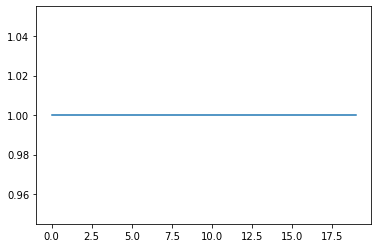

In [573]:
plt.plot([m.cost for m in g.listOfMales])

0.6165170278164006

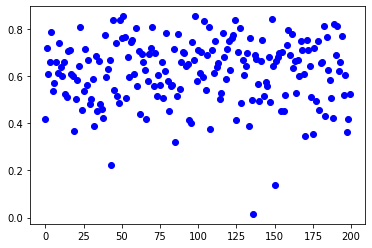

In [556]:
plt.plot(g.listOfCorrels, 'bo')
statistics.mean(g.listOfCorrels)

In [533]:
[m.demand for m in g.listOfMales]

[5, 10, 11, 15, 3, 5, 12, 8, 17, 17, 17, 7, 16, 10, 9, 13, 19, 14, 13, 19]

In [472]:
-scipy.stats.spearmanr([m.fitness for m in g.listOfMales],[m.dominance for m in g.listOfMales])[0]

0.393984962406015

0.530024344833617

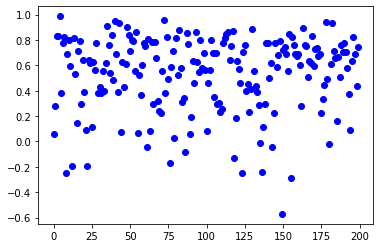

In [441]:
plt.plot(g.listOfCorrels, 'bo')
statistics.mean(g.listOfCorrels)

In [ ]:
print([round(m.effort,2) for m in g.listOfMales])
print([round(m.dominance,2) for m in g.listOfMales])
print([round(m.fitness,2) for m in g.listOfMales])
print([round(m.reproductiveSuccess,2) for m in g.listOfMales])

In [ ]:
plt.plot([round(m.fitness,2) for m in g.listOfMales], [round(m.dominance,2) for m in g.listOfMales], 'bo')

In [ ]:
statistics.mean([m.effort for m in g.listOfMales])

In [ ]:
nFemales = 5
nMales = 5
seasonality = 0.8

meanDaysToConception = 60
sdDaysToConception = 10

palette = np.flip(sns.color_palette("viridis",5550))
nGenerations = 1

plt.figure(figsize=(17, 15))
#for s in arange(0.0, 1.1, 0.1):
a = 0
for n in [5,15,25,40,65,85,100,200,300,500]:
    nFemales = n
    nMales = n
    #seasonality = s
    rangeOfNonCyclingDays = 365 - (365 * seasonality)
    g = groupOfFemales()
    g.go()

    totalProb = [0] * g.modelDays
    for i in range(g.modelDays):
        totalProb[i] =  sum([f.myConceptionProbabilityList[i] for f in g.listOfFemales]) + a*20

    allDaysTotal = plt.plot(range(g.modelDays), totalProb, color = palette[round(a*250)])
    plt.ylim([0,300])
    
    a += 1

In [56]:
nFemales = 40
seasonality = 1.0

meanDaysToConception = 60
sdDaysToConception = 10

rangeOfNonCyclingDays = 365 - (365 * seasonality)

cycleLength = 28

ovulation = 16
pre = ovulation - 6
post = cycleLength - pre - 6
conceptionProbabilityList = [0] * pre + [.05784435,.16082819,.19820558,.25408223,.24362408,.10373275] + [0] * post


g = groupOfFemales()
g.go()
    
plt.figure(figsize=(20, nFemales / 2))
allDays = plt.scatter([range(g.modelDays)] * nFemales, [[f.myConceptionProbabilityList[i] + f.ID
                                    for i in range(g.modelDays)]
                                   for f in g.listOfFemales], s=8)

totalProb = [0] * g.modelDays

for i in range(g.modelDays):
    totalProb[i] =  sum([f.myConceptionProbabilityList[i] for f in g.listOfFemales]) - 2
    
allDaysTotal = plt.scatter([range(g.modelDays)], totalProb)



In [57]:
groupConceptionProbabilities = []
lenFertilePerDay = len(fertilePerDay)

nFemales = 10

for d in range(g.modelDays):
    groupConceptionProbabilities += [sum([0 if f.myConceptionProbabilityList[d] == False else 1 for f in g.listOfFemales])]
    
fertilePerDay = [groupConceptionProbabilities.count(i) / g.modelDays for i in range(nFemales + 1)]

for day in np.flip(range(len(fertilePerDay))):
    if fertilePerDay[day] ==  0:
        fertilePerDay.pop(day)
    else:
        break

t = 0
for i in range(len(fertilePerDay)):
    t += (groupConceptionProbabilities.count(i) / g.modelDays)
    fertilePerDay += [t]
    

d = pd.DataFrame([[round(f*cycleLength,1) for f in fertilePerDay],
                  [f for f in range(round(len(fertilePerDay)/2))]*2,
                  ["day" for f in range(round(len(fertilePerDay)/2))] +
                  ["cumulative" for f in range(round(len(fertilePerDay)/2))]],
                 index=["numberFertile", "day", "category"]).T

plt.figure(figsize=(18, 5))
fertilePerDayPlot = sns.barplot("day", "numberFertile", data = d, hue = 'category')

plt.bar_label(fertilePerDayPlot.containers[0], size = 13)
plt.bar_label(fertilePerDayPlot.containers[1], size = 13)
xlabel = plt.xlabel('Number of females in POP', size=25)
ylabel = plt.ylabel('Average number of days per cycle', size=25)
ylim = plt.ylim([0,110])

NameError: name 'fertilePerDay' is not defined

In [60]:
nFemales = 10
nMales = 10
seasonality = 0.0

meanDaysToConception = 60
sdDaysToConception = 10

rangeOfNonCyclingDays = 365 - (365 * seasonality)

cycleLength = 28

ovulation = 16
pre = ovulation - 6
post = cycleLength - pre - 6
conceptionProbabilityList = [0] * pre + [.05784435,.16082819,.19820558,.25408223,.24362408,.10373275] + [0] * post

g = groupOfFemales()
g.go()

totalProb = [0] * g.modelDays
for i in range(g.modelDays):
    totalProb[i] =  sum([f.myConceptionProbabilityList[i] for f in g.listOfFemales])
    
plt.figure(figsize=(20, nFemales / 2))
allDays = plt.scatter([range(g.modelDays)] * nFemales, [[f.myConceptionProbabilityList[i] + f.ID
                                    for i in range(g.modelDays)]
                                   for f in g.listOfFemales], s=8)

totalProb = [0] * g.modelDays
for i in range(g.modelDays):
    totalProb[i] =  sum([f.myConceptionProbabilityList[i] for f in g.listOfFemales]) - 5
    
allDaysTotal = plt.scatter([range(g.modelDays)], totalProb)


In [ ]:
groupConceptionProbabilities = []
lenFertilePerDay = g.modelDays

for d in range(g.modelDays):
    groupConceptionProbabilities += [sum([0 if f.myConceptionProbabilityList[d] == False else 1 for f in g.listOfFemales])]
    
fertilePerDay = [groupConceptionProbabilities.count(i) / g.modelDays for i in range(nFemales + 1)]

for day in np.flip(range(len(fertilePerDay))):
    if fertilePerDay[day] ==  0:
        fertilePerDay.pop(day)
    else:
        break

t = 0
for i in range(len(fertilePerDay)):
    t += (groupConceptionProbabilities.count(i) / g.modelDays)
    fertilePerDay += [t]
    

d = pd.DataFrame([[round(f*cycleLength,1) for f in fertilePerDay],
                  [f for f in range(round(len(fertilePerDay)/2))]*2,
                  ["day" for f in range(round(len(fertilePerDay)/2))] +
                  ["cumulative" for f in range(round(len(fertilePerDay)/2))]],
                 index=["numberFertile", "day", "category"]).T

plt.figure(figsize=(18, 5))
fertilePerDayPlot = sns.barplot("day", "numberFertile", data = d, hue = 'category')

plt.bar_label(fertilePerDayPlot.containers[0], size = 13)
plt.bar_label(fertilePerDayPlot.containers[1], size = 13)
xlabel = plt.xlabel('Number of females in POP', size=25)
ylabel = plt.ylabel('Average number of days per cycle', size=25)
ylim = plt.ylim([0,110])